In [2]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

from functools import partial

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Creating dataset

In [2]:
#choose which dictionary to use
choice =       'mfcc'# 'logfilter' #
useDelta =  False

data = {}

#retrieving of used values for the computation of mfcc
with open('variables/mfccValues.pkl', 'rb') as f:  
    values = pickle.load(f)
    
selected = 0

if choice == 'mfcc':
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/mfccDictDD'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/mfccDict'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #loading in usedDict of the mfcc dict
        with open(name, 'rb') as f: 
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

elif choice == 'logfilter':
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/logfiltDictDD'+functions.getName(index)+'[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/logfiltDict'+functions.getName(index)+'[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #saving in usedDict of the logfilter dict
        with open(name, 'rb') as f:  
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

Loaded variables/mfccDictTrain[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictTest[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictValidation[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictAugmentedTrain[nC=14 wL=0.025 wS=0.01].pkl


In [3]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
usedLabels = words

usedLabels.append('silence')

unknownLabels = list(data['Train'].keys())
for key in usedLabels:
    try:
        unknownLabels.remove(key)
    except:
        print(key, ' not in used')

In [4]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    data,
    usedLabels,
    unknownLabels,
    with_unknown = True,
    scalerType = 'robust',
    depth = (len(data['Train'][words[0]].shape)-3)*2 + 1 )

print()


Wall time: 8.57 s


In [1]:
%reset -f 
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([0])")

<IPython.core.display.Javascript object>

# Import data

In [3]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [4]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.9 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 20
epochSGD = 15

epochs = [epoch, epochSGD]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

optimizers = [adam, sgd]

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

titles = ['Adam History', 'SGD History']

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Sequential Models

## Model1

MODEL1
Using optimizer number 0
Train on 40179 samples, validate on 4832 samples
Epoch 1/20
40179/40179 [==============================] - 9s 220us/step - loss: 2.0158 - acc: 0.3403 - top3_acc: 0.6393 - val_loss: 1.5363 - val_acc: 0.5447 - val_top3_acc: 0.8303
Epoch 2/20
40179/40179 [==============================] - 7s 167us/step - loss: 1.3782 - acc: 0.5387 - top3_acc: 0.8298 - val_loss: 1.6238 - val_acc: 0.6565 - val_top3_acc: 0.9007
Epoch 3/20
40179/40179 [==============================] - 7s 167us/step - loss: 1.0422 - acc: 0.6629 - top3_acc: 0.8913 - val_loss: 1.0304 - val_acc: 0.7763 - val_top3_acc: 0.9394
Epoch 4/20
40179/40179 [==============================] - 7s 167us/step - loss: 0.8863 - acc: 0.7222 - top3_acc: 0.9110 - val_loss: 1.0253 - val_acc: 0.7924 - val_top3_acc: 0.9431
Epoch 5/20
40179/40179 [==============================] - 7s 167us/step - loss: 0.7908 - acc: 0.7577 - top3_acc: 0.9237 - val_loss: 1.0567 - val_acc: 0.8204 - val_top3_acc: 0.9503
Epoch 6/20
40179/40

<IPython.core.display.Javascript object>


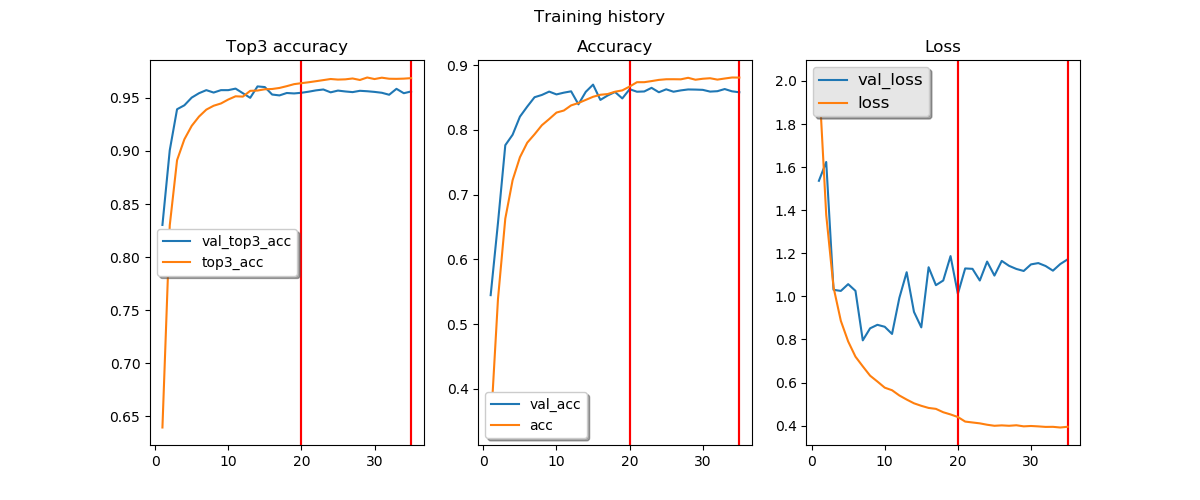

Normalized confusion matrix


<IPython.core.display.Javascript object>


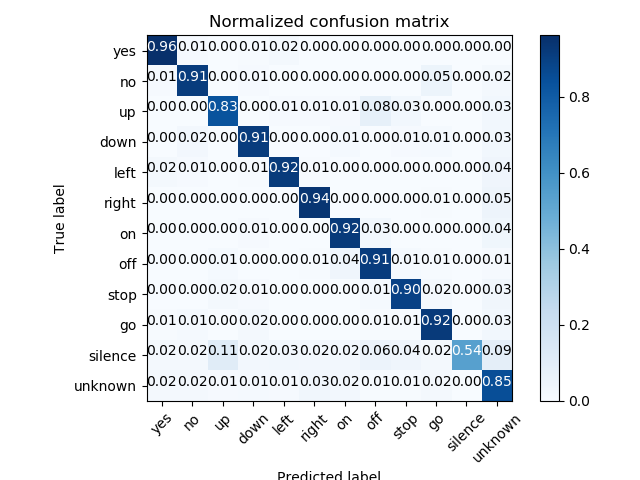

5265/5265 [==============================] - 0s 82us/step
Precision:  84.1 %
Wall time: 3min 54s


In [6]:
%%time
%matplotlib notebook
print("MODEL1")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('model1', dataset, labels)

cnn = models.model1(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 59509 samples, validate on 4832 samples
Epoch 1/20
59509/59509 [==============================] - 11s 182us/step - loss: 1.9228 - acc: 0.3760 - top3_acc: 0.6757 - val_loss: 1.4797 - val_acc: 0.5408 - val_top3_acc: 0.8313
Epoch 2/20
59509/59509 [==============================] - 9s 145us/step - loss: 1.2126 - acc: 0.6012 - top3_acc: 0.8665 - val_loss: 1.4430 - val_acc: 0.6846 - val_top3_acc: 0.9183
Epoch 3/20
59509/59509 [==============================] - 9s 145us/step - loss: 0.8854 - acc: 0.7217 - top3_acc: 0.9114 - val_loss: 0.8003 - val_acc: 0.8204 - val_top3_acc: 0.9551
Epoch 4/20
59509/59509 [==============================] - 9s 145us/step - loss: 0.7397 - acc: 0.7729 - top3_acc: 0.9295 - val_loss: 0.7568 - val_acc: 0.8349 - val_top3_acc: 0.9621
Epoch 5/20
59509/59509 [==============================] - 9s 145us/step - loss: 0.6546 - acc: 0.8021 - top3_acc: 0.9388 - val_loss: 0.7571 - val_acc: 0.8427 - val_top3_acc: 0.9638


<IPython.core.display.Javascript object>


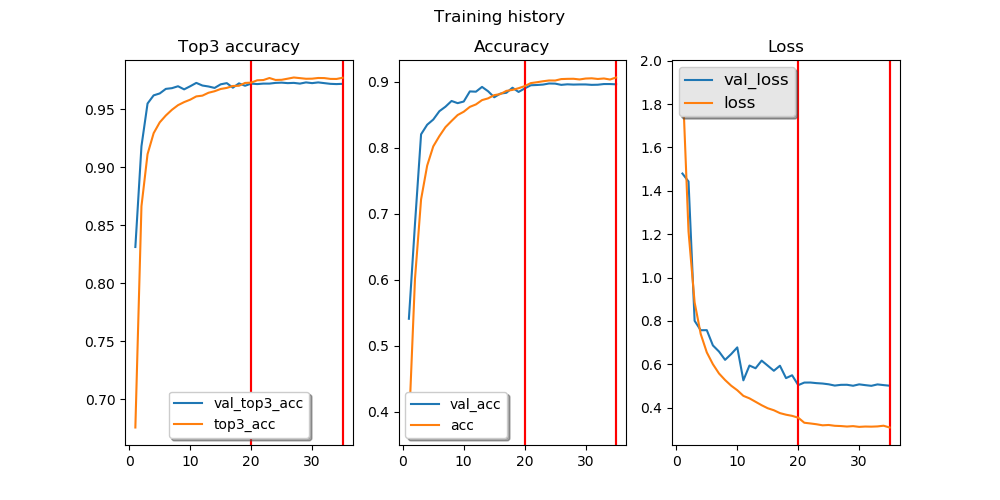

Normalized confusion matrix


<IPython.core.display.Javascript object>


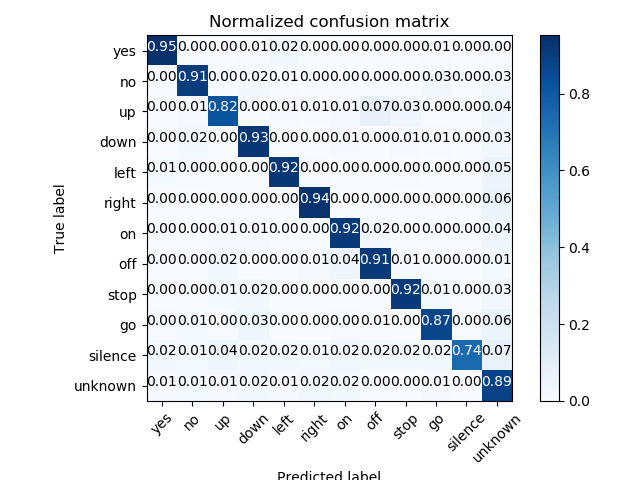

5265/5265 [==============================] - 0s 84us/step
Precision:  88.3 %
Wall time: 5min 1s


In [7]:
%%time
%matplotlib notebook
cnn = models.model1(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)
#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

name = 'cnn1.bak'
#cnn.save(dest_directory + name)

## Model2


MODEL2
Using optimizer number 0
Train on 40179 samples, validate on 4832 samples
Epoch 1/20
40179/40179 [==============================] - 24s 585us/step - loss: 2.2361 - acc: 0.2311 - top3_acc: 0.4578 - val_loss: 1.9120 - val_acc: 0.3286 - val_top3_acc: 0.6207
Epoch 2/20
40179/40179 [==============================] - 21s 518us/step - loss: 1.7192 - acc: 0.3988 - top3_acc: 0.7062 - val_loss: 1.4356 - val_acc: 0.5269 - val_top3_acc: 0.8048
Epoch 3/20
40179/40179 [==============================] - 21s 519us/step - loss: 1.3826 - acc: 0.5306 - top3_acc: 0.8131 - val_loss: 1.0432 - val_acc: 0.6805 - val_top3_acc: 0.8951
Epoch 4/20
40179/40179 [==============================] - 21s 519us/step - loss: 1.1823 - acc: 0.6073 - top3_acc: 0.8588 - val_loss: 0.8664 - val_acc: 0.7316 - val_top3_acc: 0.9243
Epoch 5/20
40179/40179 [==============================] - 21s 522us/step - loss: 1.0446 - acc: 0.6604 - top3_acc: 0.8862 - val_loss: 0.7314 - val_acc: 0.7829 - val_top3_acc: 0.9445
Epoch 6/20
40

<IPython.core.display.Javascript object>


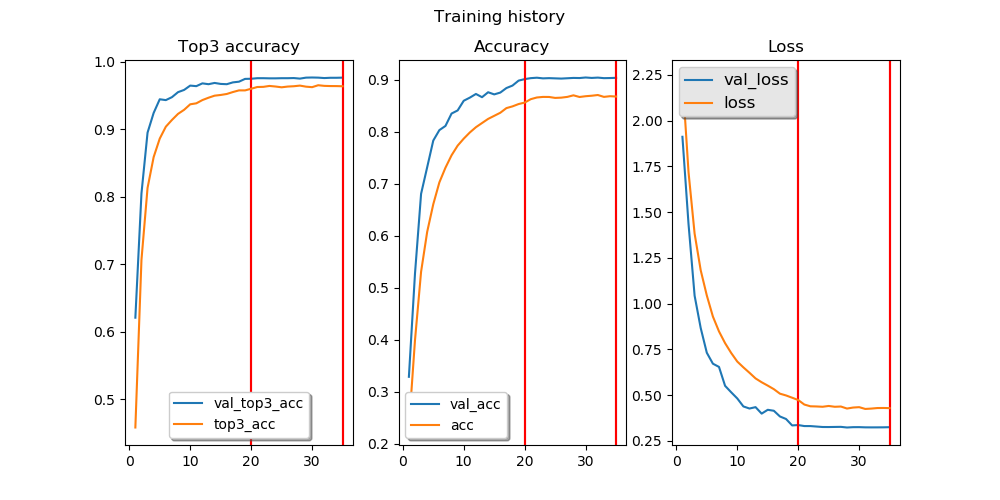

Normalized confusion matrix


<IPython.core.display.Javascript object>


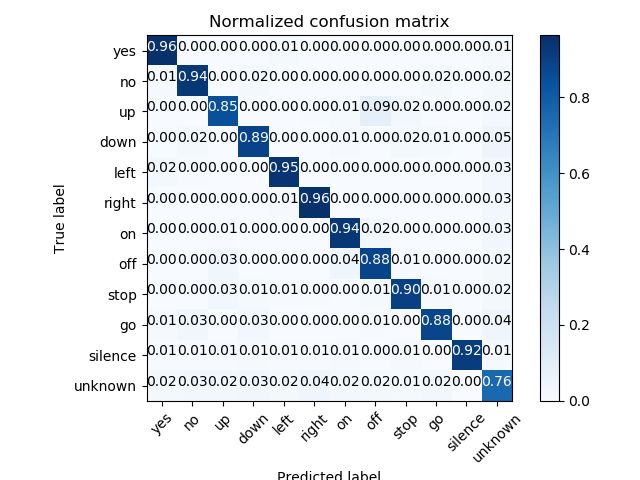

5265/5265 [==============================] - 1s 186us/step
Precision:  89.1 %
Wall time: 11min 48s


In [8]:
%%time
%matplotlib notebook
print("\nMODEL2")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('model2', dataset, labels)

cnn = models.model2(inputData,inputLabel, baseDim = 48)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 59509 samples, validate on 4832 samples
Epoch 1/20
59509/59509 [==============================] - 30s 510us/step - loss: 2.3594 - acc: 0.1766 - top3_acc: 0.3729 - val_loss: 3.4533 - val_acc: 0.1540 - val_top3_acc: 0.3291
Epoch 2/20
59509/59509 [==============================] - 28s 463us/step - loss: 1.8252 - acc: 0.3574 - top3_acc: 0.6544 - val_loss: 1.6053 - val_acc: 0.4605 - val_top3_acc: 0.7844
Epoch 3/20
59509/59509 [==============================] - 28s 463us/step - loss: 1.4784 - acc: 0.4989 - top3_acc: 0.7901 - val_loss: 1.3567 - val_acc: 0.5424 - val_top3_acc: 0.8204
Epoch 4/20
59509/59509 [==============================] - 28s 463us/step - loss: 1.1701 - acc: 0.6127 - top3_acc: 0.8642 - val_loss: 0.9011 - val_acc: 0.7082 - val_top3_acc: 0.9129
Epoch 5/20
59509/59509 [==============================] - 28s 464us/step - loss: 1.0021 - acc: 0.6750 - top3_acc: 0.8925 - val_loss: 0.8474 - val_acc: 0.7326 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


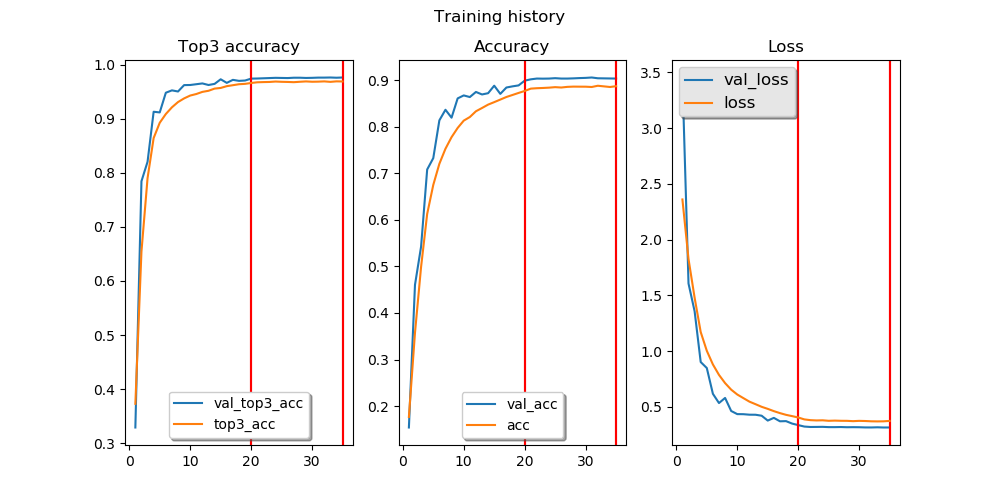

Normalized confusion matrix


<IPython.core.display.Javascript object>


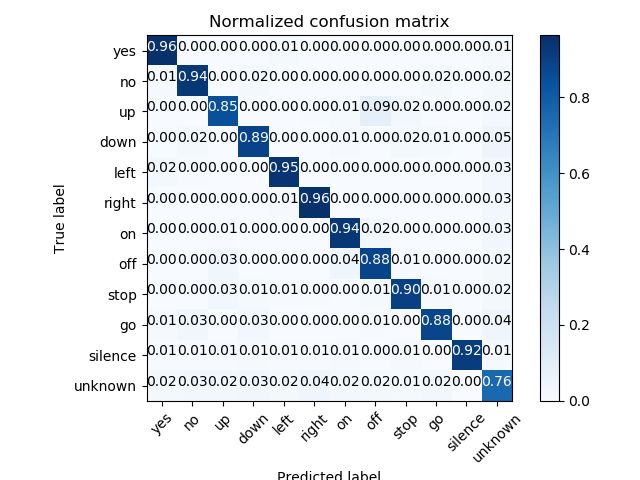

5265/5265 [==============================] - 1s 185us/step
Precision:  89.57 %
Wall time: 16min 4s


In [9]:
%%time
%matplotlib notebook
cnn = models.model2(inputData,inputLabel, baseDim = 48)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")
name = 'cnn2.bak'
#cnn.save(dest_directory + name)

## TinyDarknet


TINYDARKNET
Using optimizer number 0
Train on 40179 samples, validate on 4832 samples
Epoch 1/20
40179/40179 [==============================] - 22s 553us/step - loss: 1.6575 - acc: 0.6317 - top3_acc: 0.8490 - val_loss: 0.7256 - val_acc: 0.7918 - val_top3_acc: 0.9421
Epoch 2/20
40179/40179 [==============================] - 17s 435us/step - loss: 0.6437 - acc: 0.8150 - top3_acc: 0.9502 - val_loss: 0.5106 - val_acc: 0.8578 - val_top3_acc: 0.9663
Epoch 3/20
40179/40179 [==============================] - 17s 435us/step - loss: 0.5059 - acc: 0.8532 - top3_acc: 0.9615 - val_loss: 0.4336 - val_acc: 0.8767 - val_top3_acc: 0.9706
Epoch 4/20
40179/40179 [==============================] - 18s 436us/step - loss: 0.4398 - acc: 0.8726 - top3_acc: 0.9682 - val_loss: 0.4258 - val_acc: 0.8748 - val_top3_acc: 0.9692
Epoch 5/20
40179/40179 [==============================] - 17s 433us/step - loss: 0.3921 - acc: 0.8869 - top3_acc: 0.9721 - val_loss: 0.3719 - val_acc: 0.8982 - val_top3_acc: 0.9754
Epoch 6/

<IPython.core.display.Javascript object>


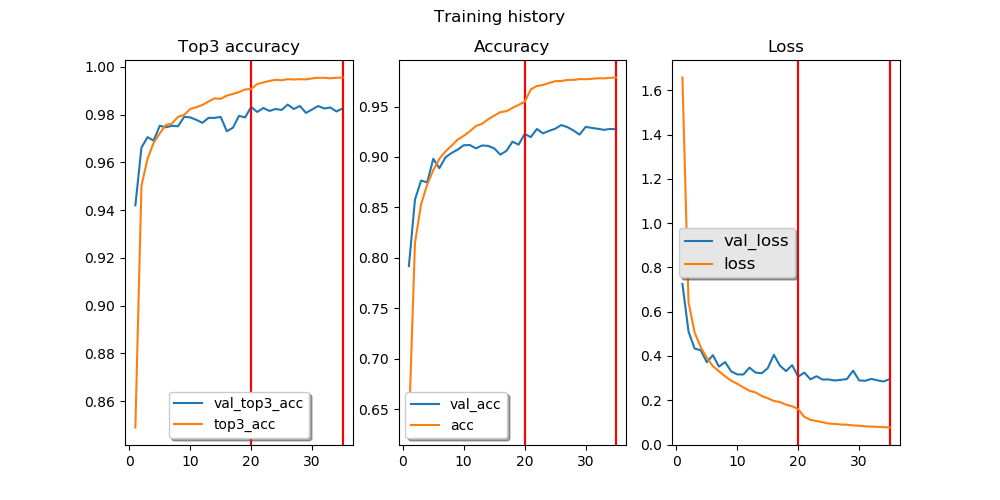

Normalized confusion matrix


<IPython.core.display.Javascript object>


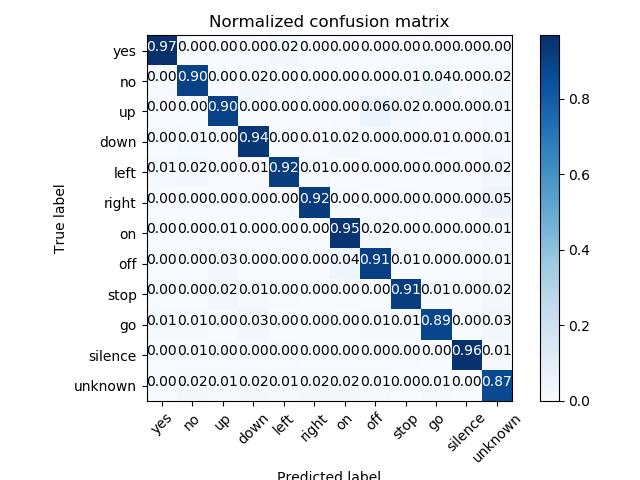

5265/5265 [==============================] - 1s 149us/step
Precision:  91.79 %
Wall time: 10min 5s


In [10]:
%%time
%matplotlib notebook
print("\nTINYDARKNET")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('tinyDarknet', dataset, labels)

cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.1)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 59509 samples, validate on 4832 samples
Epoch 1/20
59509/59509 [==============================] - 28s 479us/step - loss: 1.4376 - acc: 0.7097 - top3_acc: 0.8851 - val_loss: 0.6238 - val_acc: 0.8204 - val_top3_acc: 0.9520
Epoch 2/20
59509/59509 [==============================] - 23s 387us/step - loss: 0.4947 - acc: 0.8566 - top3_acc: 0.9618 - val_loss: 0.5205 - val_acc: 0.8537 - val_top3_acc: 0.9652
Epoch 3/20
59509/59509 [==============================] - 23s 382us/step - loss: 0.3901 - acc: 0.8863 - top3_acc: 0.9707 - val_loss: 0.5170 - val_acc: 0.8622 - val_top3_acc: 0.9708
Epoch 4/20
59509/59509 [==============================] - 23s 383us/step - loss: 0.3359 - acc: 0.9023 - top3_acc: 0.9758 - val_loss: 0.3415 - val_acc: 0.9021 - val_top3_acc: 0.9772
Epoch 5/20
59509/59509 [==============================] - 23s 383us/step - loss: 0.2937 - acc: 0.9144 - top3_acc: 0.9797 - val_loss: 0.3946 - val_acc: 0.8911 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


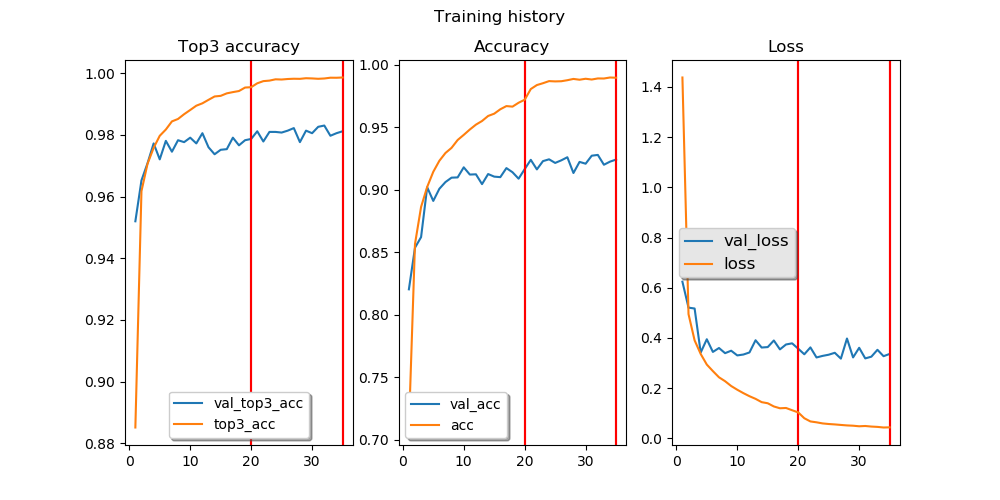

Normalized confusion matrix


<IPython.core.display.Javascript object>


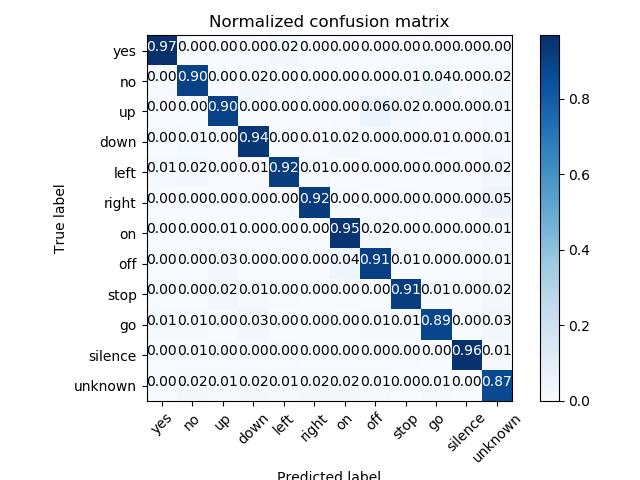

5265/5265 [==============================] - 1s 158us/step
Precision:  91.05 %
Wall time: 13min 17s


In [11]:
%%time
%matplotlib notebook
cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.1)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

name = 'tinyDarknet.bak'
#cnn.save(dest_directory + name)

# Inception

## Single output

Using optimizer number 0
Train on 40179 samples, validate on 4832 samples
Epoch 1/20
40179/40179 [==============================] - 14s 360us/step - loss: 1.8471 - acc: 0.3584 - top3_acc: 0.6285 - val_loss: 1.0469 - val_acc: 0.6440 - val_top3_acc: 0.8934
Epoch 2/20
40179/40179 [==============================] - 11s 277us/step - loss: 1.0476 - acc: 0.6594 - top3_acc: 0.8837 - val_loss: 0.6909 - val_acc: 0.7707 - val_top3_acc: 0.9375
Epoch 3/20
40179/40179 [==============================] - 11s 277us/step - loss: 0.8242 - acc: 0.7350 - top3_acc: 0.9185 - val_loss: 0.5676 - val_acc: 0.8129 - val_top3_acc: 0.9536
Epoch 4/20
40179/40179 [==============================] - 11s 277us/step - loss: 0.7171 - acc: 0.7725 - top3_acc: 0.9334 - val_loss: 0.5037 - val_acc: 0.8388 - val_top3_acc: 0.9572
Epoch 5/20
40179/40179 [==============================] - 11s 276us/step - loss: 0.6427 - acc: 0.7961 - top3_acc: 0.9411 - val_loss: 0.4559 - val_acc: 0.8506 - val_top3_acc: 0.9644
Epoch 6/20
40179/4017

<IPython.core.display.Javascript object>


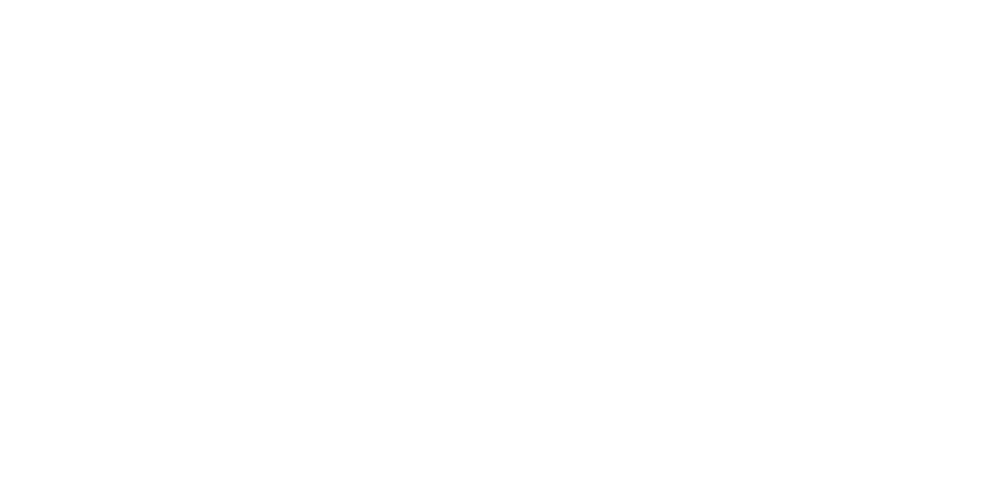

Normalized confusion matrix


<IPython.core.display.Javascript object>


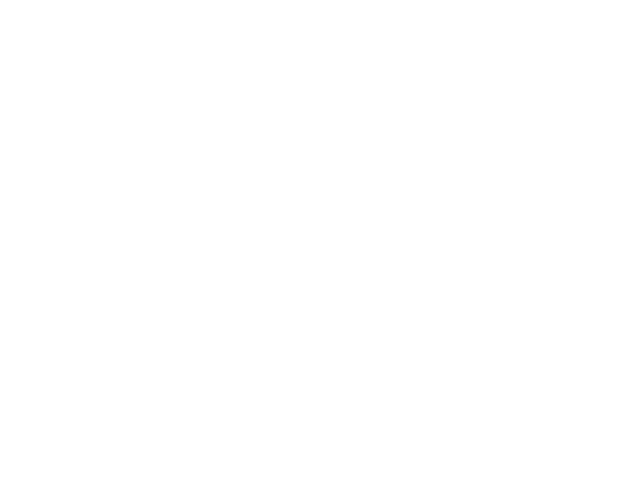

5265/5265 [==============================] - 1s 135us/step
Precision:  89.84 %
Wall time: 6min 30s


In [12]:
%%time
%matplotlib notebook
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('SiSoInc', dataset, labels)

cnn = models.SiSoInception(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

In [13]:
%%time
%matplotlib notebook
cnn = models.SiSoInception(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 59509 samples, validate on 4832 samples
Epoch 1/20
59509/59509 [==============================] - 18s 305us/step - loss: 1.7477 - acc: 0.3952 - top3_acc: 0.6508 - val_loss: 0.9305 - val_acc: 0.6829 - val_top3_acc: 0.9116
Epoch 2/20
59509/59509 [==============================] - 14s 242us/step - loss: 0.9026 - acc: 0.7063 - top3_acc: 0.9054 - val_loss: 0.6280 - val_acc: 0.7866 - val_top3_acc: 0.9472
Epoch 3/20
59509/59509 [==============================] - 14s 242us/step - loss: 0.6994 - acc: 0.7777 - top3_acc: 0.9352 - val_loss: 0.5088 - val_acc: 0.8280 - val_top3_acc: 0.9594
Epoch 4/20
59509/59509 [==============================] - 14s 242us/step - loss: 0.6112 - acc: 0.8075 - top3_acc: 0.9445 - val_loss: 0.4548 - val_acc: 0.8498 - val_top3_acc: 0.9667
Epoch 5/20
59509/59509 [==============================] - 14s 242us/step - loss: 0.5457 - acc: 0.8292 - top3_acc: 0.9515 - val_loss: 0.4216 - val_acc: 0.8601 - val_top3_acc: 0.9

KeyboardInterrupt: 

## Multiple input

In [ ]:
%%time
mfcc = True
%matplotlib notebook
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('MiSoInc', dataset, labels)

print(labels['Train'].shape)
cnn = models.MiSoInception(inputData, inputLabel, mfcc = mfcc)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

In [ ]:
%%time
%matplotlib notebook
cnn = models.MiSoInception(inputData,inputLabel, , mfcc = mfcc)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

## Multiple output

In [ ]:
%%time
%matplotlib notebook
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('SiMoInc', dataset, labels)

cnn = models.SiMoInception(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

In [ ]:
%%time
%matplotlib notebook
cnn = models.SiMoInception(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds[0], testLabel[0], classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

# Score

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = k.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= k.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = k.clip(y_pred, k.epsilon(), 1 - k.epsilon())
        # calc
        loss = y_true * k.log(y_pred) * weights
        loss = -k.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
#find prediction with test data
%matplotlib notebook
preds = cnn.predict(testData)
#Plot normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

#print(list(used))

In [ ]:
preds = cnn.predict(validData)
plt.figure()
cm = functions.plot_confusion_matrix(preds, validLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix', plot = True)

weights = np.diagonal(1 - cm).copy()
#weights /= np.max(weights)

weights = (1-weights) * 2

print(weights)

ncce1 = weighted_categorical_crossentropy(weights)
ncce1.__name__ ='w_categorical_crossentropy'


In [ ]:
compiledSGD = cnn.compile(loss=ncce1, optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights=loss_weights)
fittedSGD = cnn.fit(inputData, inputLabel,
                     epochs=epochSGD,
                     batch_size=round(inputData.shape[0]/400),
                     validation_data=validation_data,
                     shuffle=True,
                     callbacks = [tbCallBack])

In [ ]:
#find prediction with test data
%matplotlib notebook
preds = cnn.predict(testData)
#Plot normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

#print(list(used))

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial